![Tulane](https://github.com/tulane-cmps6730/main/blob/main/img/banner.png?raw=true)

<center>

<font size="+3">Transformers</font>

[Aron Culotta](https://cs.tulane.edu/~aculotta/)  
[Tulane University](https://cs.tulane.edu/)

<a href="http://colab.research.google.com/github/tulane-cmps6730/main/blob/main/notebooks/10_Transformers.ipynb">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/320px-Google_Colaboratory_SVG_Logo.svg.png"  width=10%/></a>
<a href="https://github.com/tulane-cmps6730/main/tree/main">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/GitHub_Invertocat_Logo.svg/240px-GitHub_Invertocat_Logo.svg.png" width=6%/></a>

In this module, we'll learn about the transformer language model, which uses attention to capture the long-range dependencies of language.

</center>

<hr size=10 color=#285C4D>

## Motivation

The GPT in ChatGPT stands for...

- **G**enerative
- **P**retrained
- **T**ransformer

Today we'll learn what this means.

### Attention for Classification Review


![figs/lstmclf4.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/lstmclf4.png?raw=1)


> Given a set of vector **values**, and a vector **query**,  
> **attention** is a technique to compute a weighted sum of the values, dependent on the query.

- a selective summary of the values based on the query
- gives a fixed-size representation of the values





**Input**: sequence of value vectors $\mathbf{h}_1 \ldots \mathbf{h}_n \in \mathbb{R}^{d_h}$ and a query vector $\mathbf{q} \in \mathbb{R}^{d_q}$

1. Compute **attention scores** $\mathbf{s} \in \mathbb{R}^n$
  - we'll see how in a moment


2. Apply softmax to get the **attention distribution** $\alpha$:
  - $\alpha = \mathrm{softmax}(\mathbf{s}) \in \mathbb{R}^n$
  
  
3. Compute the **attention output**, the sum of values weighted by attention distribution:
  - $\mathbf{a} = \sum_i^n \alpha_i \mathbf{h}_i \in \mathbb{R}^{d_h}$
  - $\mathbf{a}$ then becomes input features for classification layer

<hr size=10 color=#285C4D>

## Self-Attention for Language Models

### Overview


- We can use the idea of attention to predict the next word in a sentence.
- Attention lets us model long-range dependencies
- The prediction for word $i$ depends on **all previous words**



![figs/m10selfatt.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10selfatt.png?raw=1)

![figs/m10selfatt2.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10selfatt2.png?raw=1)

We can use attention to determine which other words are important to predict the next word $t$.

$$\mathbf{a}_i =  \sum_{j \le i}^n \alpha_{ij} \mathbf{v}_j$$



Each input embedding plays three different roles:

- As the current focus of attention when being compared to all of the other preceding inputs. We’ll refer to this role as a **query**.
- As a preceding input being compared to the current focus of attention. We’ll refer to this role as a **key**.
- As a **value** used to compute the output for the current focus of attention.

We use three different weight matrices to represent each role.

$\mathbf{v}_j = W_v\mathbf{x_j} ~~~W_v\in \mathbb{R}^{dxd} ~~~$ **values for node j**

$\mathbf{k}_j = W_k \mathbf{x}_j ~~~W_k\in \mathbb{R}^{dxd} ~~~$ **keys for node j**

$\mathbf{q}_i = W_q\mathbf{x_i}~~~$ **query for node i**

$\alpha_{ij} = \frac{\exp(\mathbf{q}_i \cdot \mathbf{k}_j)}{\sum_{j'} \exp({\mathbf{q}_i \cdot \mathbf{k}_{j'})}} ~~~$ **affinities between node i and j**

**nb:** we often scale down dot product for better numerical stability:
$\alpha_{ij} = \frac{\exp(\mathbf{q}_i \cdot \mathbf{k}_j) / \sqrt{d_k}}{\sum_{j'} \exp({\mathbf{q}_i \cdot \mathbf{k}_{j'})}}$

**Putting it all together:**

![figs/m10selfatt3.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10selfatt3.png?raw=1)


### Word Embeddings and Unembeddings



To use self-attention for language modeling, we need two additional layers.
- **Embedding layer**: from one-hot encoding of input word to a dense word embedding vector


![figs/m10selfatt2.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10embed.png?raw=1)

$$\mathbf{x}_i \times E = \mathbf{e}_i$$

$$ \begin{bmatrix}0&1&0&0\end{bmatrix} \times \begin{bmatrix}.1&.2\\.3&.4\\-.1&-.2\\.5&.5\end{bmatrix}  = \begin{bmatrix}.3&.4\end{bmatrix}$$

<br><br>
Finally, for the output of the model, we need a way to convert from this embedding space back to the vocabulary space.

- **Unembedding layer**: from a dense word embedding vector to a distribution over output words

Can use $E^T$ to convert from output of attention layer to logits over word outputs.

$$ \mathbf{u}_i = \mathbf{a}_i E^T$$

$$ \begin{bmatrix}.3&.4\end{bmatrix} \times \begin{bmatrix}.1&.3&-.1&.5\\.2&.4&-.2&.5\end{bmatrix}  = \begin{bmatrix}.11&.25&-.11&.35\end{bmatrix}$$

Then take softmax to get distribution over words in vocabulary:

$$\mathbf{y_i} = \mathrm{softmax}(\mathbf{u}_i)$$

\begin{bmatrix} 0.2367 & 0.2723 & 0.1900 & 0.3010 \end{bmatrix}

Thus, the most likely next word in this example is the fourth word in the vocabulary (Pr=.3010)


### Efficient multiplication



Rather than computing attention one word at a time, we can construct a matrix of all word embeddings, and perform matrix multiplications to get matrices $\mathbf{Q}, \mathbf{K}, \mathbf{V}$. This is much more efficient than a series of vector-matrix multiplications, since this operations can be highly parallelized in GPUs.

To do so:
$$
Q = XW_q ; K = XW_k ; V = XW_v
$$

Then, to perform query-key comparisons, another matrix multiplication can be used:

$$QK^t$$

The final attention values matrix then becomes:

$$A = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$


### Self-Attention Example
Let's work through an example computing attention for the sentence "a a b c"

- We'll assume an embedding of size 2

In [1]:
import torch

"""
Assume three words in the vocabulary (a=0,b=1,c=2).
One-hot encoding of the sentence "a a b c" is:
"""
# 1. Create one-hot encoddings of sentence.
word1 = torch.tensor([1.,0.,0.])
word2 = torch.tensor([1.,0.,0.])
word3 = torch.tensor([0.,1.,0.])
word4 = torch.tensor([0.,0.,1.])
sentence = torch.vstack([word1,word2,word3, word4])
sentence

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [2]:
# 2. Create word embedding matrix X

# Assume our embeddings are size 2.
# Let's use random values for the embedding.
# E has dimension V x d
# V=vocab size   d=embedding dimension
# So, row i is the embedding for word i
E = torch.tensor([[.1,.2],[.3,.4],[-.1,-.2]])
E

tensor([[ 0.1000,  0.2000],
        [ 0.3000,  0.4000],
        [-0.1000, -0.2000]])

In [3]:
# 3. Compute embeddings for entire sentence in one matrix multiplication.
sentence_embeddings = sentence @ E  # <--- note matrix multiplication operator @
sentence_embeddings

tensor([[ 0.1000,  0.2000],
        [ 0.1000,  0.2000],
        [ 0.3000,  0.4000],
        [-0.1000, -0.2000]])

In [4]:
# 4. Create attention weight matrices
# W_q,W_k,W_v matrix all dxd
torch.manual_seed(24)
# random, but multiplying by scalars to get some larger values.
W_q = torch.randn(2,2) * 5
W_k = torch.randn(2,2) * 10
W_v = torch.randn(2,2) * 3
W_q, W_k, W_v

(tensor([[ 5.0697,  4.4942],
         [-1.0553, -7.6630]]),
 tensor([[ -6.1630,   2.2882],
         [ -1.1195, -20.5059]]),
 tensor([[-1.8566, -2.3413],
         [-2.7651,  1.4420]]))

In [5]:
# 5. Compute Q,K,V matrices with matrix multiplication.
Q = sentence_embeddings @ W_q
K = sentence_embeddings @ W_k
V = sentence_embeddings @ W_v
Q,K,V

(tensor([[ 0.2959, -1.0832],
         [ 0.2959, -1.0832],
         [ 1.0988, -1.7170],
         [-0.2959,  1.0832]]),
 tensor([[-0.8402, -3.8723],
         [-0.8402, -3.8723],
         [-2.2967, -7.5159],
         [ 0.8402,  3.8723]]),
 tensor([[-0.7387,  0.0543],
         [-0.7387,  0.0543],
         [-1.6630, -0.1256],
         [ 0.7387, -0.0543]]))

In [6]:
# 6. Compute similarity scores between all queries and keys.
similarities = Q @ K.T
similarities

tensor([[ 3.9459,  3.9459,  7.4615, -3.9459],
        [ 3.9459,  3.9459,  7.4615, -3.9459],
        [ 5.7255,  5.7255, 10.3810, -5.7255],
        [-3.9459, -3.9459, -7.4615,  3.9459]])

In [7]:
# 7. Compute softmax of similarities (alphas)
from torch.nn.functional import softmax
import math
# divide by sqrt(dimension) to reduce scale of values
sm = softmax(similarities/math.sqrt(2), dim=-1) # normalize by rows
sm
# So, value .0037 in last row means to create output for last word, the first word contributes .0037 of its value vector to the last word.

tensor([[7.1346e-02, 7.1346e-02, 8.5704e-01, 2.6907e-04],
        [7.1346e-02, 7.1346e-02, 8.5704e-01, 2.6907e-04],
        [3.4609e-02, 3.4609e-02, 9.3077e-01, 1.0536e-05],
        [3.7420e-03, 3.7420e-03, 3.1151e-04, 9.9220e-01]])

In [8]:
# 8. Multiply by values.
print('mutiplying similarity matrix Q*K^T (NxN)')
print(sm)
print('\nby value matrix (V) [one row per word in sentence]')
print(V)
A = sm @ V
print('\n\nresult (A) [one row per word in sentence]')
A

mutiplying similarity matrix Q*K^T (NxN)
tensor([[7.1346e-02, 7.1346e-02, 8.5704e-01, 2.6907e-04],
        [7.1346e-02, 7.1346e-02, 8.5704e-01, 2.6907e-04],
        [3.4609e-02, 3.4609e-02, 9.3077e-01, 1.0536e-05],
        [3.7420e-03, 3.7420e-03, 3.1151e-04, 9.9220e-01]])

by value matrix (V) [one row per word in sentence]
tensor([[-0.7387,  0.0543],
        [-0.7387,  0.0543],
        [-1.6630, -0.1256],
        [ 0.7387, -0.0543]])


result (A) [one row per word in sentence]


tensor([[-1.5305, -0.0999],
        [-1.5305, -0.0999],
        [-1.5990, -0.1132],
        [ 0.7269, -0.0535]])

In [9]:
# 9. Unembed
logits = A @ E.T
logits
# result is N x d. One row for each word in sentence with scores for possible words in that location.

tensor([[-0.1730, -0.4991,  0.1730],
        [-0.1730, -0.4991,  0.1730],
        [-0.1825, -0.5250,  0.1825],
        [ 0.0620,  0.1967, -0.0620]])

In [10]:
# 10. Softmax to get probability of each word in the sentence.
probas = softmax(logits, dim=-1)
probas

tensor([[0.3190, 0.2302, 0.4508],
        [0.3190, 0.2302, 0.4508],
        [0.3174, 0.2254, 0.4572],
        [0.3303, 0.3779, 0.2918]])

In [143]:
# 11. Pick top prediction for each element.
vocabulary = np.array(["a", "b", "c"])
topi = probas.argmax(dim=-1)
most_probable_words = vocabulary[topi]
most_probable_words

array(['c', 'c', 'c', 'b'], dtype='<U1')

### Using only the past to predict the future



There was a problem in the above example

```python
similarities = Q @ K.T

tensor([[ 3.9459,  3.9459,  7.4615, -3.9459],
        [ 3.9459,  3.9459,  7.4615, -3.9459],
        [ 5.7255,  5.7255, 10.3810, -5.7255],
        [-3.9459, -3.9459, -7.4615,  3.9459]])
```

We have been assuming that word $i$ can only attend to **previous** words in the sentence (up to and including $i$):

$$\mathbf{a}_i =  \sum_{j \le i}^n \alpha_{ij} \mathbf{v}_j$$

But, in the calculations above, word $i$ attended **all** the words in the sentence. (`Q @ K.T`)

**Solution:** Just "mask out" the future values in the similarity matrix before computing softmax.

![figs/m10mask.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10mask.png?raw=1)


In [12]:
# Compute new similarity matrix QK^T while keeping future values at -inf
# triu = upper trianglular
# diagonal=1 === keep diagonal
similarities + torch.triu(torch.full_like(similarities, float('-inf')), diagonal=1)

tensor([[ 3.9459,    -inf,    -inf,    -inf],
        [ 3.9459,  3.9459,    -inf,    -inf],
        [ 5.7255,  5.7255, 10.3810,    -inf],
        [-3.9459, -3.9459, -7.4615,  3.9459]])

In [13]:
# when we softmax, the -inf becomes 0
def mask_future(similarities):
    return similarities + torch.triu(torch.full_like(similarities, float('-inf')), diagonal=1)

sm = softmax(mask_future(similarities)/math.sqrt(2), dim=-1) # normalize by rows
sm

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.0000e-01, 5.0000e-01, 0.0000e+00, 0.0000e+00],
        [3.4609e-02, 3.4609e-02, 9.3078e-01, 0.0000e+00],
        [3.7420e-03, 3.7420e-03, 3.1151e-04, 9.9220e-01]])

In [144]:
# doesn't actually change prediction in this example ;)
A = sm @ V
logits = A @ E.T
probas = softmax(logits, dim=-1)
most_probable_words = vocabulary[probas.argmax(dim=-1)]
most_probable_words

array(['c', 'c', 'c', 'b'], dtype='<U1')

In [121]:
P = nn.Linear(2, 4, bias=False)
torch.eye(4) @ P.weight

tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153]], grad_fn=<MmBackward0>)

<hr size=10 color=#285C4D>

## Implementation: Simple Attention-based Language Model

In [201]:
# Let's package these computations up inside of an nn.Module.
import pandas as pd
import torch
import torch.nn as nn


class SimpleSelfAttention(nn.Module):
  def __init__(self, vocab_size, embedding_size, seq_len,
               use_positional_embedding=True, verbose=False):
    super(SimpleSelfAttention, self).__init__()
    self.embedding_size = embedding_size
    self.vocab_size = vocab_size
    self.seq_len = seq_len
    self.verbose = verbose
    self.use_positional_embedding = use_positional_embedding

    # word embedding and unembedding
    self.E = nn.Linear(embedding_size, vocab_size, bias=False)

    # position embedding and unembedding
    self.P = nn.Linear(embedding_size, seq_len, bias=False)

    # attention weights
    # values
    self.W_v = nn.Linear(embedding_size, embedding_size)
    # keys
    self.W_k = nn.Linear(embedding_size, embedding_size)
    # queries
    self.W_q = nn.Linear(embedding_size, embedding_size)
    self.softmax = nn.Softmax(dim=-1)



  def mask_future(self, similarities):
    return similarities + torch.triu(torch.full_like(similarities, float('-inf')), diagonal=1)

  def forward(self, x):
    # using self. for these temporary values below so we can debug later on
    # embed words
    self.sentence_embeddings = x @ self.E.weight
    if self.use_positional_embedding:
      # embed positions
      self.pos_embedding = torch.eye(self.seq_len) @ self.P.weight
      # sum word and position embeddings
      self.sentence_embeddings += self.pos_embedding
    # Q,K,V
    self.Q = self.W_q(self.sentence_embeddings)
    self.K = self.W_k(self.sentence_embeddings)
    self.V = self.W_v(self.sentence_embeddings)
    self.similarities = self.Q @ self.K.T
    # normalize by rows
    self.sm = self.softmax(self.mask_future(self.similarities)/math.sqrt(self.embedding_size))
    self.A = self.sm @ self.V
    self.logits = self.A @ self.E.weight.T
    # leave as logits for crossentropy loss later.
    if self.verbose:
      print('A matrix (words x embed_size)')
      display(pd.DataFrame(
              pp(self.A)
              ))
      print('logits (words x vocab_size)')
      display(pd.DataFrame(
              pp(logits)
              ))
    return self.logits

def pp(arr):
  # pretty print weight array
  return arr.detach().cpu().numpy().round(decimals=2)


In [239]:
sentence

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [202]:
torch.manual_seed(24)
ssa = SimpleSelfAttention(vocab_size=3, embedding_size=2, seq_len=4,
                          use_positional_embedding=True, verbose=True)
logits = ssa.forward(sentence)

A matrix (words x embed_size)


,0,1
0,-0.24,-0.22
1,-0.14,-0.07
2,-0.38,-0.30
3,-0.29,-0.20


logits (words x vocab_size)


,0,1,2
0,-0.05,0.14,-0.09
1,-0.04,0.08,-0.07
2,-0.09,0.21,-0.15
3,-0.07,0.16,-0.13


**training code is same as in LSTM lecture**

In [203]:
# @title
# same as our previous train_model functions...
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, data, epochs=20, learning_rate=0.1, batch_size=10):
    """
    Iterate through the data in batches and train the model.
    """
    torch.random.manual_seed(42)  # for reproducibility
    np.random.seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    model.verbose = False
    loss_val = []
    # main training loop
    for epoch in range(epochs):
        print('epoch=%d' % epoch)
        np.random.shuffle(data)
        epoch_loss = 0
        # for each batch of instances
        with tqdm(total=len(data), desc=f'Epoch {epoch+1}/{epochs}', unit='sample') as pbar:
          for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            optimizer.zero_grad() # reset all the gradient information
            batch_loss = 0
            for datum in batch:
                result = model.forward(datum[:-1])
                loss = criterion(result,
                                 datum[1:].argmax(dim=1).long())
                batch_loss += loss
            # change parameters after each batch
            batch_loss /= batch_size
            batch_loss.backward()       # computes all the gradients
            optimizer.step()            # update parameters
            loss_val.append(batch_loss.item())
            epoch_loss += batch_loss
            pbar.update(len(batch))
            pbar.set_postfix({'Batch': (i // batch_size) + 1, 'Loss': batch_loss.item()})

        avg_epoch_loss = epoch_loss / (len(data) / batch_size)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}')


    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    return model

### Testing on "abc" example

In [204]:
def char2vec(char, char2int):
    x = torch.zeros((1, len(char2int)))
    x[0][char2int[char]] = 1
    return x

def chars2vec(chars, char2int):
    return torch.cat([char2vec(c, char2int) for c in chars])

chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}
data = [
    chars2vec('abcabcabc', char2int),
    chars2vec('bcabcabca', char2int),
    chars2vec('cabcabcab', char2int)
]  * 100

len(data)

300

epoch=0


Epoch 1/2: 100%|██████████| 300/300 [00:00<00:00, 758.94sample/s, Batch=30, Loss=0]


Epoch [1/2], Average Loss: 0.5075
epoch=1


Epoch 2/2: 100%|██████████| 300/300 [00:00<00:00, 515.42sample/s, Batch=30, Loss=0]


Epoch [2/2], Average Loss: 0.0000


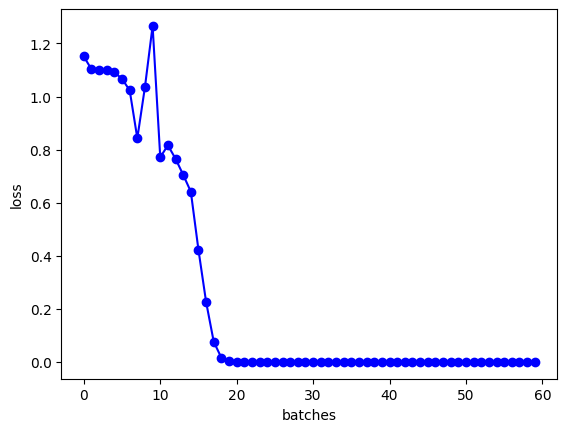

SimpleSelfAttention(
  (E): Linear(in_features=2, out_features=3, bias=False)
  (P): Linear(in_features=2, out_features=8, bias=False)
  (W_v): Linear(in_features=2, out_features=2, bias=True)
  (W_k): Linear(in_features=2, out_features=2, bias=True)
  (W_q): Linear(in_features=2, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [205]:
torch.manual_seed(24)
ssa = SimpleSelfAttention(vocab_size=3, embedding_size=2, seq_len=8,
                          use_positional_embedding=True, verbose=True)
train_model(ssa, data, epochs=2, learning_rate=.2, batch_size=10)

In [206]:
x = chars2vec('abcabcabc', char2int)
outputs = ssa.forward(x[:-1])
vocabulary[outputs.argmax(axis=1)]

array(['b', 'c', 'a', 'b', 'c', 'a', 'b', 'c'], dtype='<U1')

In [207]:
ssa.E.weight

Parameter containing:
tensor([[-2.7532,  2.0580],
        [-1.4466, -2.6530],
        [ 3.8879,  0.0807]], requires_grad=True)

### Testing on long-range example

Let's revisit the synthetic task from LSTM lecture. We observe two types of sequences:

> 'bc**a**bcbcbc**a**'

> 'bcbcbcbcbc'

The network needs to learn that when it sees an 'a', it must remember this in order to output another 'a' 7 time steps later.

epoch=0


Epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 458.72sample/s, Batch=2, Loss=0.982]


Epoch [1/10], Average Loss: 1.0025
epoch=1


Epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 513.75sample/s, Batch=2, Loss=0.935]


Epoch [2/10], Average Loss: 0.9226
epoch=2


Epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 516.64sample/s, Batch=2, Loss=0.811]


Epoch [3/10], Average Loss: 0.8645
epoch=3


Epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 512.36sample/s, Batch=2, Loss=0.648]


Epoch [4/10], Average Loss: 0.7218
epoch=4


Epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 445.60sample/s, Batch=2, Loss=0.375]


Epoch [5/10], Average Loss: 0.4791
epoch=5


Epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 491.60sample/s, Batch=2, Loss=0.21]


Epoch [6/10], Average Loss: 0.2426
epoch=6


Epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 529.90sample/s, Batch=2, Loss=0.177]


Epoch [7/10], Average Loss: 0.1926
epoch=7


Epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 498.18sample/s, Batch=2, Loss=0.123]


Epoch [8/10], Average Loss: 0.1220
epoch=8


Epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 555.38sample/s, Batch=2, Loss=0.156]


Epoch [9/10], Average Loss: 0.1300
epoch=9


Epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 471.73sample/s, Batch=2, Loss=0.102]


Epoch [10/10], Average Loss: 0.1123


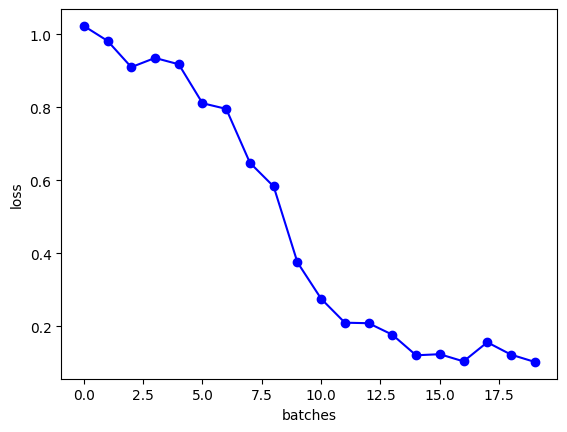

SimpleSelfAttention(
  (E): Linear(in_features=2, out_features=3, bias=False)
  (P): Linear(in_features=2, out_features=9, bias=False)
  (W_v): Linear(in_features=2, out_features=2, bias=True)
  (W_k): Linear(in_features=2, out_features=2, bias=True)
  (W_q): Linear(in_features=2, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [208]:
data2 = [
    chars2vec('bcabcbcbca', char2int),
    chars2vec('bcbcbcbcbc', char2int),
]  * 10

ssa2 = SimpleSelfAttention(vocab_size=3, embedding_size=2, seq_len=9,
                           use_positional_embedding=True, verbose=True)
train_model(ssa2, data2, epochs=10, learning_rate=.1, batch_size=10)

In [209]:
# predct "a" in last position?
x = chars2vec('bcabcbcbca', char2int)
outputs = ssa2.forward(x[:-1])
vocabulary[outputs.argmax(axis=1)]

array(['c', 'b', 'b', 'c', 'b', 'c', 'b', 'c', 'a'], dtype='<U1')

In [222]:
pd.Index(chars[:-1], name='input')

Index(['b', 'c', 'a', 'b', 'c', 'b', 'c', 'b', 'c'], dtype='object', name='input')

### Examining attention weights

**Can we see the model "paying attention" to the "c" to predict "a" at the end??**

In [236]:
# examine the softmax attention weights (sm)
inputs = list('bcabcbcbca')
index = pd.Index(['%d_%s' % (i, char) for i, char in enumerate(inputs[:-1])], name='input')
att = pd.DataFrame(ssa2.sm.detach().numpy(), index=index)
att.columns = ['%d_%s' % (i, char) for i, char in enumerate(inputs[:-1])]
# Convert tensor to Pandas DataFrame
att.style.background_gradient(cmap='viridis')


,0_b,1_c,2_a,3_b,4_c,5_b,6_c,7_b,8_c
input,,,,,,,,,
0_b,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1_c,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2_a,0.000001,0.000000,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3_b,0.999771,0.000000,0.000000,0.000228,0.000000,0.000000,0.000000,0.000000,0.000000
4_c,0.000000,0.006434,0.992655,0.000291,0.000620,0.000000,0.000000,0.000000,0.000000
5_b,0.996653,0.000026,0.000000,0.000045,0.000143,0.003133,0.000000,0.000000,0.000000
6_c,0.000000,0.000503,0.999412,0.000007,0.000018,0.000000,0.000060,0.000000,0.000000
7_b,0.380413,0.013113,0.000000,0.000116,0.015945,0.015243,0.020024,0.555145,0.000000
8_c,0.000001,0.743515,0.000116,0.000020,0.037162,0.000078,0.163638,0.000560,0.054910


In [237]:
# predict "c" in last position?
x = chars2vec('bcbcbcbcbc', char2int)
outputs = ssa2.forward(x[:-1])
vocabulary[outputs.argmax(axis=1)]

array(['c', 'b', 'c', 'b', 'c', 'b', 'c', 'b', 'c'], dtype='<U1')

In [238]:
# examine the softmax attention weights (sm)
inputs = list('bcbcbcbcbc')
index = pd.Index(['%d_%s' % (i, char) for i, char in enumerate(inputs[:-1])], name='input')
att = pd.DataFrame(ssa2.sm.detach().numpy(), index=index)
att.columns = ['%d_%s' % (i, char) for i, char in enumerate(inputs[:-1])]
# Convert tensor to Pandas DataFrame
att.style.background_gradient(cmap='viridis')


,0_b,1_c,2_b,3_c,4_b,5_c,6_b,7_c,8_b
input,,,,,,,,,
0_b,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1_c,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2_b,0.999723,0.000001,0.000277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3_c,0.000000,0.000002,0.000162,0.999836,0.000000,0.000000,0.000000,0.000000,0.000000
4_b,0.922738,0.000015,0.000005,0.000000,0.077242,0.000000,0.000000,0.000000,0.000000
5_c,0.000000,0.000234,0.000064,0.997756,0.000000,0.001946,0.000000,0.000000,0.000000
6_b,0.534869,0.002683,0.000191,0.000001,0.222202,0.000193,0.239860,0.000000,0.000000
7_c,0.000000,0.001894,0.000003,0.994302,0.000000,0.003631,0.000000,0.000170,0.000000
8_b,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999


<hr size=10 color=#285C4D>


## Transformers



A **transformer** block is a collection of ideas. But, at its core, it contains a *self-attention layer* and *positional embeddings*.

Other components include:




### Feedforward Layer



An additional 2-layer network (one hidden layer). This allows an additional transformation of the $A$ representation. Typically, the dimensionality is increased in this layer from $A$ to $O$. E.g.,

$$O = FFN(A) = ReLU((AW_{o1})W_{o2})$$

where $W_{o1}$ has dimension $d \times 2d$, $W_{o2}$ has dimension $2d \times d$ and $ReLU$ is activation function $=\max(0, x)$. (2 is a bit arbitrary here.)

In [255]:
# FFN example:
W_o1 = torch.tensor([[.1,.2, .3,.4],[-.1,-.2, -.3, -.4]]) # 2x4
W_o2 = torch.tensor([[.31,.22], [.23,.41],[-.11,-.22], [-.35, -.4]]) # 4x2
O = nn.ReLU()((A @ W_o1) @ W_o2)
O

tensor([[0.0761, 0.0967],
        [0.0761, 0.0967],
        [0.1426, 0.1813],
        [0.0000, 0.0000]])

### Multi-head attention



Multiple attention layers are run for each input sentence. This allows different layers to pay attention to different parts of the input. E.g., one can pay attention to syntax, another semantics, etc.

E.g., for a 4-head attention block, run the entire attention network 4 times for each word, then **concatenate** all the $A$ outputs together. Pass to the FFN.

![figs/m10multi.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10multi.png?raw=1)



### Residual Connections

A simple trick that adds the input to the final output of a network.

- For both forward and gradient computations, helps information get transferred more efficiently between layers.
- Particularly helpful in deep networks (many layers) to that information is not forgotten.
- Somewhat analogous to vanishing gradient problem

 $$X_i = X_{i-1} + \mathrm{Layer}(X_i)$$

 E.g., for the simple attention network.

 output = A + sentence_embedding


### Layer norm

Compute *z*-scores for values in each layer (subtract mean and divide by standard deviation)
  - can improve training convergence by placing weights in same "scale" across layers
  - Normalization is done separately for each word in the input:

$$\mu_i = \frac{1}{d}\sum_{j=1}^d \mathbf{a}_{ij}$$

$$\sigma_i = \sqrt{\frac{1}{d}\sum_{j=1}^d (\mu_i - \mathbf{a}_{ij})}$$

$$
\mathbf{a}_i = \frac{\mathbf{a}_i - \mu_i}{\sigma}
$$


### Full transformer

For input X representing $N$ input words each with embedding size $d$:

$$
\begin{align}
T^1 = & \hbox{SelfAttention}(X)\\
T^2 = & X + T^1~~~~~~~~~\hbox{residual connection}\\
T^3 = & \hbox{LayerNorm}(T^2)\\
T^4 = & \hbox{FFN}(T^3)\\
T^5 = & T^4 + T^3~~~~~~~~\hbox{residual connection}\\
H = & \hbox{LayerNorm}(T^5)
\end{align}
$$

![figs/m10transformer.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/m10transformer.png?raw=1)


<hr size=10 color=#285C4D>

## Transformer Variants

### Original Transformer


The transformer was originally introduced for a machine translation task. Below is the figure from original paper "Attention Is All You Need" (2017)

![figs/attention.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/attention.png?raw=1)

### BERT

BERT is a "multi-layer bidirectional Transformer encoder"
- to train, mask words at random so that information about word $i$ is not used when predicting word $i$

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/bert.png?raw=1" width=60%/>

**Just the Encoder portion of the original Transformer architecture**


### GPT: Generative Pre-trained Transformer



**Just the Decoder portion of the original Transformer architecture**

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/gpt.png?raw=1" width=60%/>


### ELMO



**Not a transformer!**

ELMO "word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pretrained on a large text corpus."

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/elmo.png?raw=1" width=60%/>



<hr size=10 color=#285C4D>

## Group Task

Re-run the `SimpleSelfAttention` example above for the long-distance example ("bcabcbcbca"), but this time do not use the positional embeddings. Is it able to capture the dependencies as well. Why or why not? Inspect the attention weights and other components of the model to see if you can identify what is different.

<hr size=10 color=#285C4D>

## Sources



- https://web.stanford.edu/class/cs224n/

- Andrej Karpathy's excellent, simplified implementation of transformer: https://github.com/karpathy/minGPT
  - Along with code walkthrough video: https://www.youtube.com/watch?v=kCc8FmEb1nY